In [121]:
import pandas as pd
import numpy as np
import yfinance as yf
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [97]:
tickers = pd.read_csv('tickers.csv')
stock_ticker = tickers.loc[tickers.groupby('Sector')['Market Cap'].idxmax()]
stocks = stock_ticker["Symbol"].tolist()
start_date = "2009-01-01"
end_date = "2019-01-01"
stocks

['BHP',
 'AMZN',
 'KO',
 'XOM',
 'HSBC',
 'LLY',
 'TMO',
 'FERG',
 'PLD',
 'AAPL',
 'CSCO',
 'SO']

In [98]:
ferg = yf.download('FERG', start = start_date, end=end_date)
ferg.shape

[*********************100%%**********************]  1 of 1 completed


(2263, 6)

In [69]:
df = yf.download('AAPL', start=start_date, end=end_date)
print(df.shape)
print(df.columns)
print(df.index)

[*********************100%%**********************]  1 of 1 completed
(2516, 6)
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
DatetimeIndex(['2009-01-02', '2009-01-05', '2009-01-06', '2009-01-07',
               '2009-01-08', '2009-01-09', '2009-01-12', '2009-01-13',
               '2009-01-14', '2009-01-15',
               ...
               '2018-12-17', '2018-12-18', '2018-12-19', '2018-12-20',
               '2018-12-21', '2018-12-24', '2018-12-26', '2018-12-27',
               '2018-12-28', '2018-12-31'],
              dtype='datetime64[ns]', name='Date', length=2516, freq=None)


In [70]:
split_idx = int(len(df)*0.8)
train = df.iloc[:split_idx]
test = df.iloc[split_idx:]
X_train = train.drop("Adj Close", axis=1)
y_train = train["Adj Close"]
X_test = test.drop("Adj Close", axis=1)
y_test = test["Adj Close"]

In [71]:
model = xgb.XGBRegressor(objective="reg:squarederror")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred

array([27.16547 , 26.687906, 26.68408 , 26.96301 , 27.19308 , 26.917645,
       26.977934, 26.919052, 26.939178, 27.028378, 26.78602 , 27.142508,
       27.011988, 26.996962, 27.06957 , 27.480013, 27.014994, 27.556599,
       27.606487, 27.468458, 27.55938 , 27.541769, 29.315062, 28.9022  ,
       28.941622, 29.417524, 29.759058, 29.721096, 29.772964, 29.754549,
       29.763056, 29.806799, 29.833054, 29.763056, 29.763056, 29.76005 ,
       29.754549, 29.754549, 29.754549, 29.754549, 29.763056, 29.843767,
       29.82886 , 29.754549, 29.754549, 29.647358, 29.647358, 29.763056,
       29.647358, 29.647358, 29.647358, 29.745024, 29.647358, 29.923283,
       29.754549, 29.856936, 29.745024, 29.754549, 29.763056, 29.763056,
       29.806799, 29.772964, 29.754549, 29.647358, 29.647358, 29.647358,
       29.744589, 29.754549, 29.647358, 29.647358, 29.806835, 29.754549,
       29.647358, 29.647358, 29.647358, 29.647358, 29.763056, 29.647358,
       29.647358, 29.647358, 29.754549, 29.647358, 

In [72]:
# Augment the df using 2 lag variables
train2 = train.copy()
test2 = test.copy()
train2["Adj Close_lag1"] = train2["Adj Close"].shift(1)
train2["Adj Close_lag2"] = train2["Adj Close"].shift(2)
test2["Adj Close_lag1"] = test2["Adj Close"].shift(1)
test2["Adj Close_lag2"] = test2["Adj Close"].shift(2)
train2.head()

,Open,High,Low,Close,Adj Close,Volume,Adj Close_lag1,Adj Close_lag2
Date,,,,,,,,
2009-01-02,3.067143,3.251429,3.041429,3.241071,2.751009,746015200,NaN,NaN
2009-01-05,3.327500,3.435000,3.311071,3.377857,2.867112,1181608400,2.751009,NaN
2009-01-06,3.426786,3.470357,3.299643,3.322143,2.819824,1289310400,2.867112,2.751009
2009-01-07,3.278929,3.303571,3.223571,3.250357,2.758891,753048800,2.819824,2.867112
2009-01-08,3.229643,3.326786,3.215714,3.310714,2.810122,673500800,2.758891,2.819824


In [73]:
train2.dropna(inplace=True)
test2.dropna(inplace=True)

In [74]:
X_train2 = train2.drop("Adj Close", axis=1)
y_train2 = train2["Adj Close"]
X_test2 = test2.drop("Adj Close", axis=1)
y_test2 = test2["Adj Close"]

In [75]:
# Sample dataset and training process
dtrain = xgb.DMatrix(X_train2, label=y_train2)
params = {
    'objective': 'reg:squarederror', 
    'eval_metric': 'rmse'
}
num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds)
y_pred2 = bst.predict(xgb.DMatrix(X_test2))

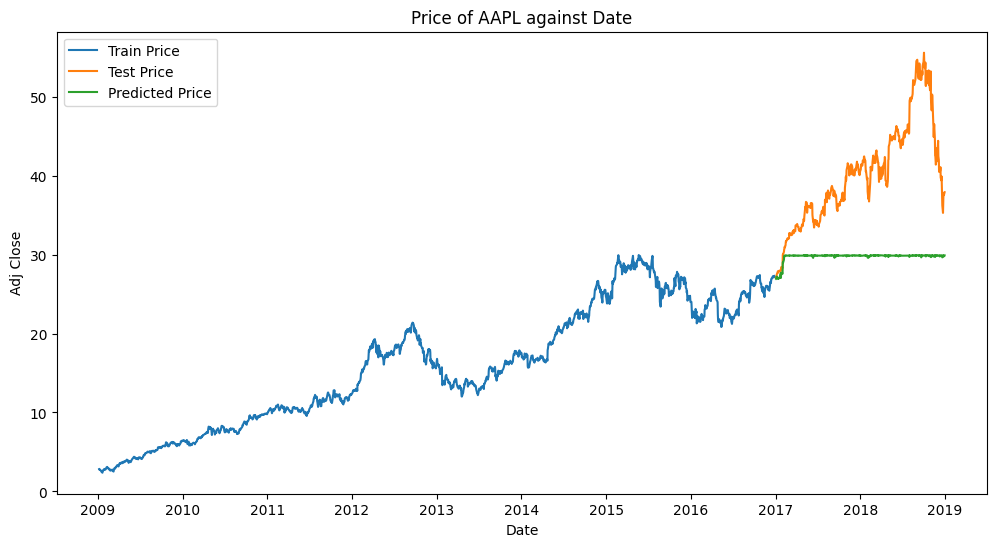

In [76]:
plt.figure(figsize=(12, 6))
plt.title("Price of AAPL against Date")
sns.lineplot(data=train2, x=train2.index, y="Adj Close", label="Train Price")
sns.lineplot(data=test2, x=test2.index, y="Adj Close", label="Test Price")
sns.lineplot(x=test2.index, y=y_pred2, label="Predicted Price")
plt.legend()
plt.show()

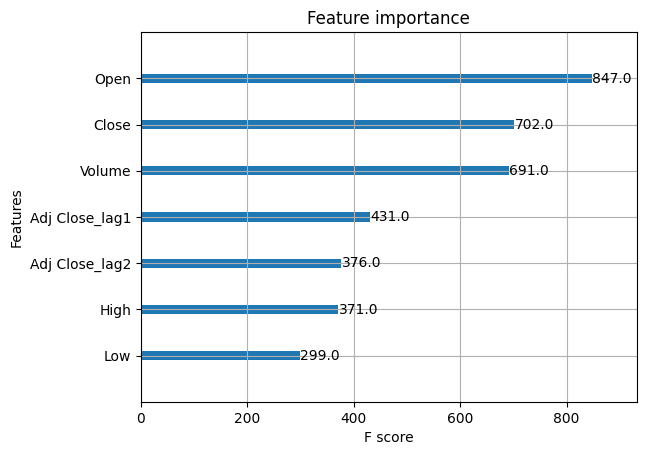

In [77]:
xgb.plot_importance(bst)
plt.show()

In [95]:
def generate_data(df, r=0.9):
    df["Adj Close_lag1"]=df["Adj Close"].shift(1)
    df["Adj Close_lag2"]=df["Adj Close"].shift(2)
    split_i = int(len(df)*r)
    train=df[:split_i]
    test=df[split_i:]
    X_train=train.drop("Adj Close", axis=1)
    y_train=train["Adj Close"]
    X_test=test.drop("Adj Close", axis=1)
    y_test=test["Adj Close"]
    print(y_test.shape)
    return X_train, y_train, X_test, y_test

In [123]:
# Train for 12 stocks in Portfolio
predictions = {}
true = {}
assigned = False
indices = None
for stock in stocks:    
    df = yf.download(stock, start=start_date, end=end_date)
    X_train, y_train, X_test, y_test = generate_data(df)
    # Sample dataset and training process
    dtrain = xgb.DMatrix(X_train, label=y_train)
    params = {
        'objective': 'reg:squarederror', 
        'eval_metric': 'rmse'
    }
    num_rounds = 100
    bst = xgb.train(params, dtrain, num_rounds)
    predictions[stock] = bst.predict(xgb.DMatrix(X_test))
    true[stock] = y_test
    if not assigned:
        indices = y_test.index
        assigned = True
    joblib.dump(bst, f"models/{stock}.joblib")
    

[*********************100%%**********************]  1 of 1 completed
(252,)
[*********************100%%**********************]  1 of 1 completed
(252,)
[*********************100%%**********************]  1 of 1 completed
(252,)
[*********************100%%**********************]  1 of 1 completed
(252,)
[*********************100%%**********************]  1 of 1 completed
(252,)
[*********************100%%**********************]  1 of 1 completed
(252,)
[*********************100%%**********************]  1 of 1 completed
(252,)
[*********************100%%**********************]  1 of 1 completed
(227,)
[*********************100%%**********************]  1 of 1 completed
(252,)
[*********************100%%**********************]  1 of 1 completed
(252,)
[*********************100%%**********************]  1 of 1 completed
(252,)
[*********************100%%**********************]  1 of 1 completed
(252,)


In [117]:
pred_df = pd.DataFrame({key: pd.Series(value) for key, value in predictions.items()})
true_df = pd.DataFrame({key: pd.Series(value) for key, value in true.items()})
pred_df.index=indices
true_df.index=indices
pred_df.shape

(252, 12)

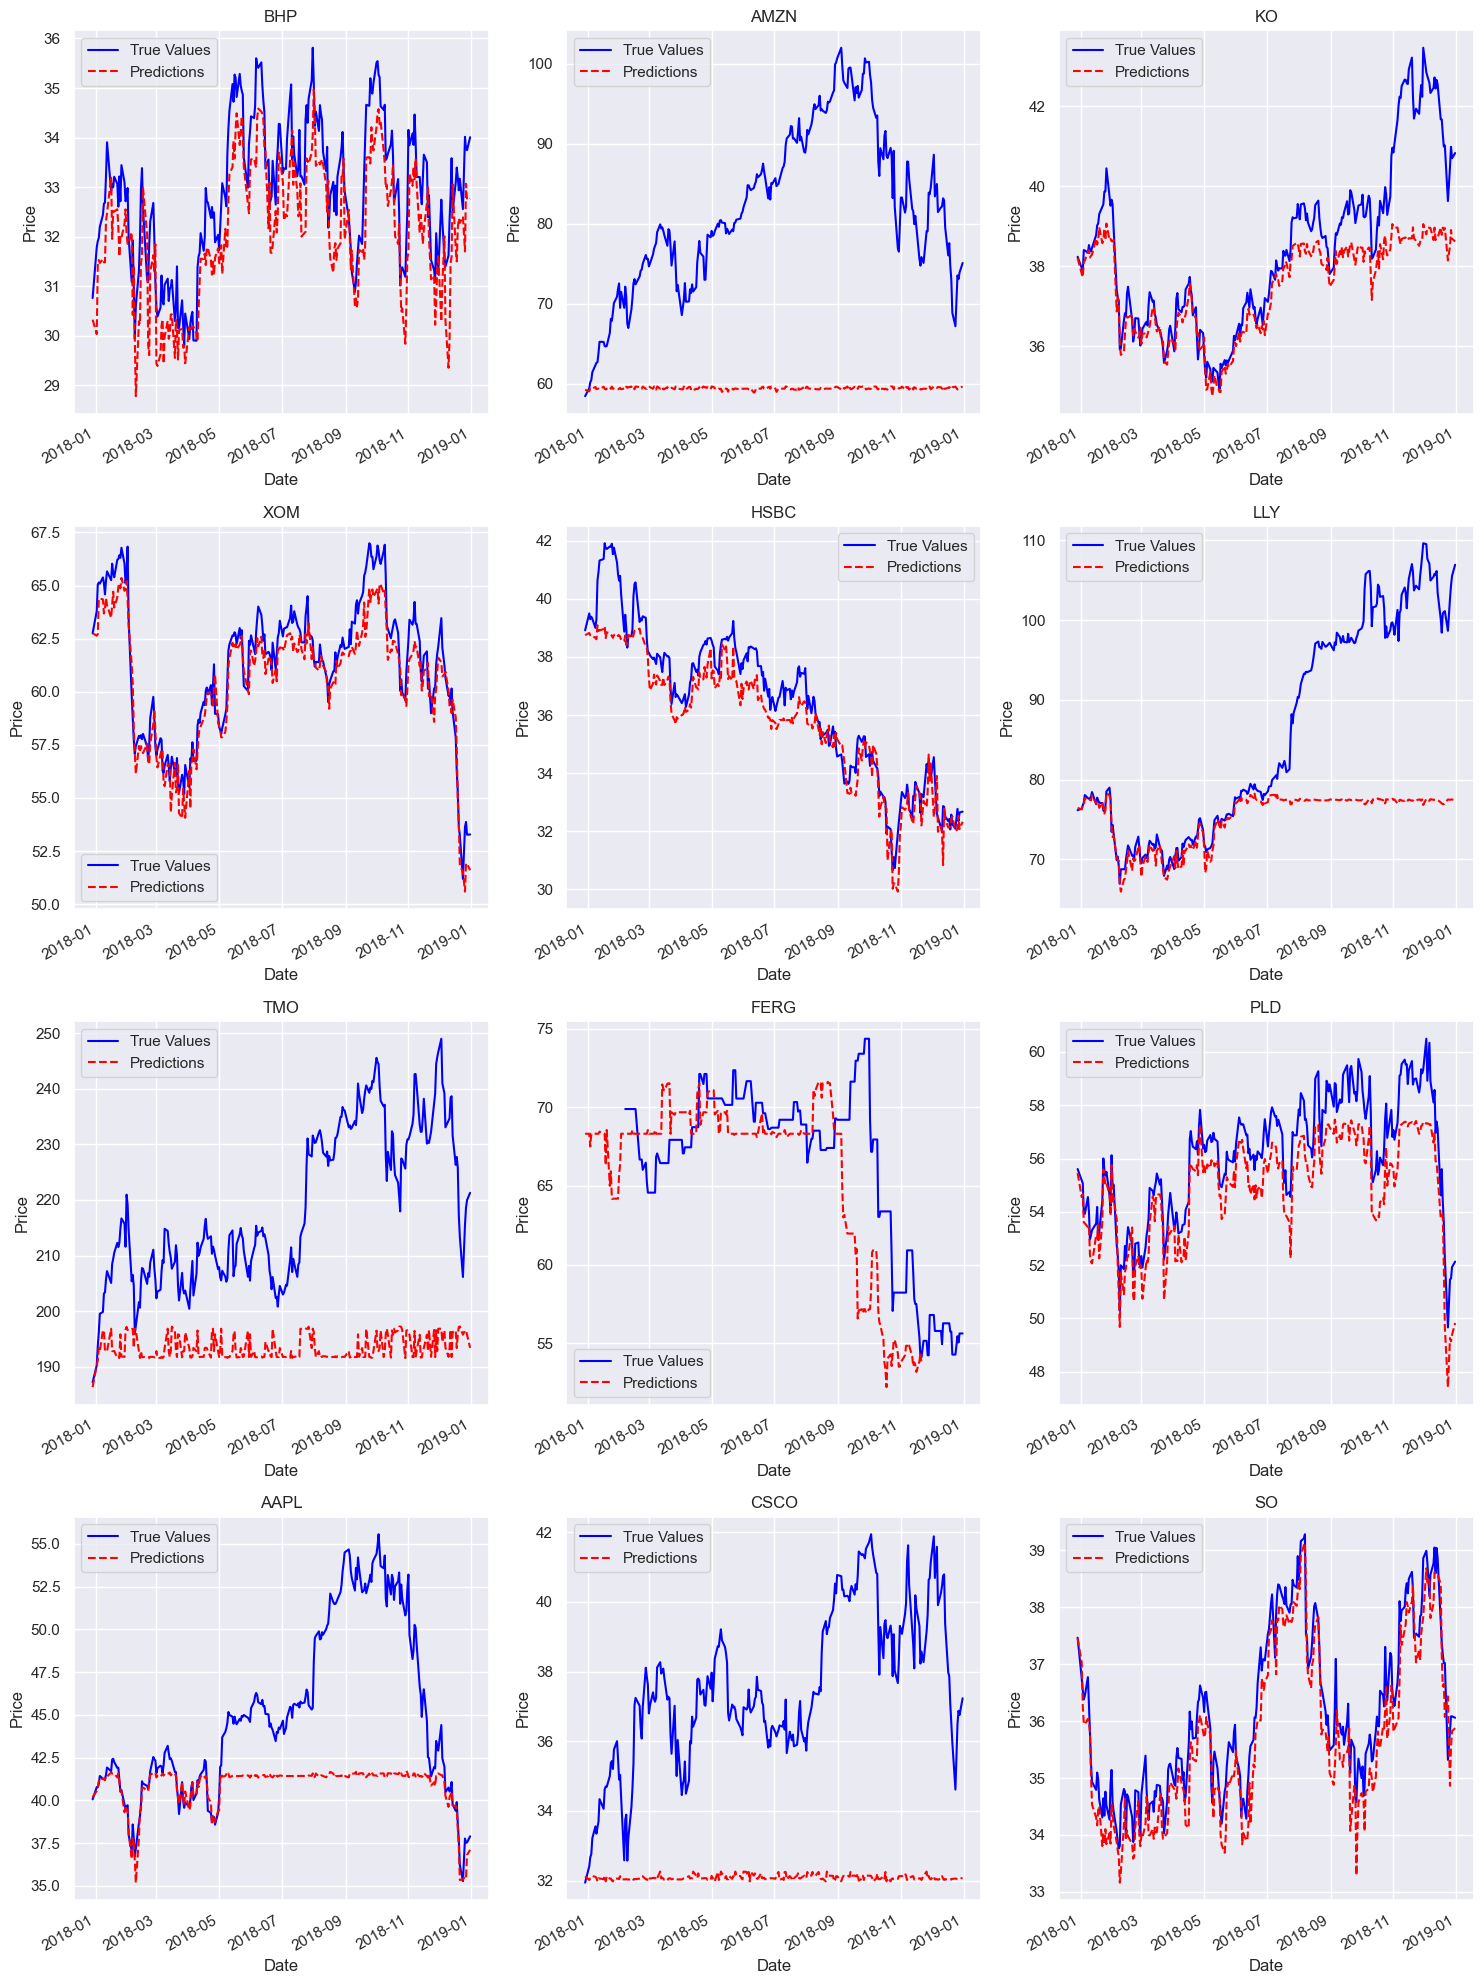

In [119]:
fig, axes = plt.subplots(4, 3, figsize=(15, 4 * 5))
for idx, stock in enumerate(pred_df.columns):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    true_df[stock].plot(ax=ax, label="True Values", color="blue")
    pred_df[stock].plot(ax=ax, label="Predictions", linestyle="--", color="red")
    
    ax.set_title(stock)
    ax.set_ylabel("Price")
    ax.legend()

plt.tight_layout()
plt.show()